In [1]:
import scanpy as sc
import torch
import sys, os
import pickle
import scvelo as scv
import numpy as np

# Get the parent directory of the current working directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Append the parent directory to sys.path
sys.path.append(parent_dir)

from model import VAE  # Now it can import from the parent directory VAE
from utils import load_model_checkpoint

In [2]:
!ls

compute_cell_mse.py	  fetch_top_GPs.ipynb	  plot_gps
downstream.ipynb	  gastrulation.ipynb	  plot_p_uncertainty.ipynb
downstream.py		  phase_plane_plots	  plot_p_uncertainty.py
downstream_individual.py  plot_GPs.ipynb	  plot_sign_uncertainty
downstream_recreate.py	  plot_gene_signal.ipynb  store_cell_loss.ipynb


In [ ]:
dataset = "forebrain"


In [3]:
dataset = "forebrain"
adata_path = f"../benchmark/imVelo/{dataset}/imVelo_{dataset}.h5ad"
checkpoint = 20035
model_path = f"../checkpoints/{dataset}/{dataset}/model_checkpoints/model_epoch_{checkpoint}.pt"
trainer_path = f"../checkpoints/{dataset}/trainer.pkl"

In [4]:
with open(trainer_path, 'rb') as file:
    trainer = pickle.load(file)
adata = sc.read_h5ad(adata_path)
model = VAE(adata, 512, "cpu")
model = load_model_checkpoint(adata, model, model_path)
trainer.device = "cpu"
trainer.model = model
trainer.adata = adata
trainer.self_extract_outputs()

Model checkpoint loaded successfully.
Confirmed that cell probabilities sum to one for all cells


In [5]:
adata.layers["velocity"] *=-1
adata.layers["velocity_u"] *=-1

computing velocity graph (using 1/24 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


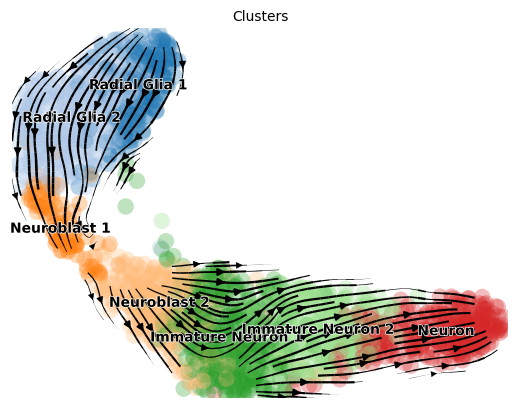

In [6]:
sc.pp.neighbors(adata)
scv.tl.velocity_graph(adata)
scv.pl.velocity_embedding_stream(adata, color="Clusters")

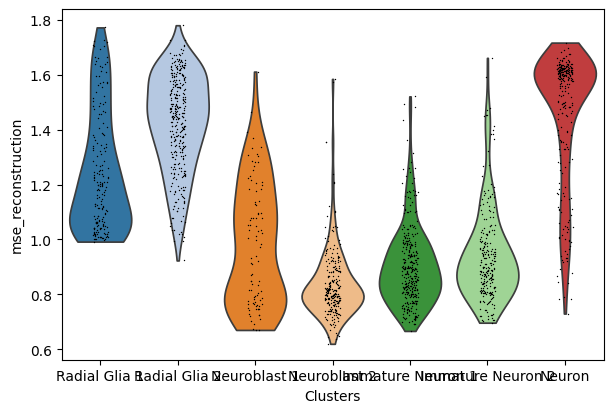

In [14]:
adata.obs["mse_reconstruction"] = np.mean((adata.obsm["recons"] - adata.obsm["MuMs"])**2, axis=1)
sc.pl.violin(adata, "mse_reconstruction", groupby="Clusters")

In [7]:
data = np.concatenate(adata.layers["Mu"], adata.layers["Ms"], axis=1)

TypeError: concatenate() got multiple values for argument 'axis'